In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, TimeDistributed,
                                     Dropout, LayerNormalization)
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.python.client import device_lib

import os

# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 10
FORECAST_STEPS = 10
TEST_RATIO = 0.3

# Tuning parameters
EPOCHS_LIST = [10, 20]
BATCH_SIZES = [64, 128]

WINDOW_SIZE_SIMULATION = 6 * 6  # 6h window
THRESHOLD_PERCENTILE = 95

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ========================
# 2. DEVICE SETUP
# ========================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")

# ========================
# 3. LOAD AND PREPROCESS DATA
# ========================
file_path = '../../csv/dataset_reduced-10min-one-target-variable-TI0036.csv'
df = pd.read_csv(file_path, delimiter=',')
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df.set_index('DateTime', inplace=True)

# Clean
df.dropna(axis=1, thresh=int(0.7 * len(df)), inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df.columns).astype(np.float32)

print(f"✅ Scaled dataset shape: {df_scaled.shape}")

# ========================
# 4. SEQUENTIAL TRAIN/TEST SPLIT
# ========================
split_idx = int((1 - TEST_RATIO) * len(df_scaled))
train_data = df_scaled.iloc[:split_idx]
test_data = df_scaled.iloc[split_idx:]

print(f"✅ Training samples: {len(train_data)}, Testing samples: {len(test_data)}")

# ========================
# 5. CREATE SEQUENCES
# ========================
def create_sequences(data, input_steps, forecast_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - forecast_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+forecast_steps])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train_seq, y_train_seq = create_sequences(train_data.values, INPUT_STEPS, FORECAST_STEPS)
X_test_seq, y_test_seq = create_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)

print(f"✅ Training sequences: {X_train_seq.shape}, Testing sequences: {X_test_seq.shape}")

# ========================
# 6. BUILD TRANSFORMER MODEL
# ========================
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.token_dense = Dense(embed_dim)
        self.pos_embedding = self.add_weight("pos_embedding", shape=[1, sequence_length, embed_dim])

    def call(self, x):
        x = self.token_dense(x)
        return x + self.pos_embedding

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config


def build_transformer_model(input_steps, input_dim, forecast_steps, embed_dim=64, num_heads=4, ff_dim=128):
    inputs = Input(shape=(input_steps, input_dim))
    x = PositionalEmbedding(input_steps, input_dim, embed_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = Dense(embed_dim, activation='relu')(x)
    x = Dense(input_dim)(x)
    outputs = x[:, -forecast_steps:, :]
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# ========================
# 7. TRAINING + TUNING
# ========================
best_val_rmse = np.inf
best_model = None
history_records = []

for epochs in EPOCHS_LIST:
    for batch_size in BATCH_SIZES:
        print(f"\n🔵 Training Transformer with epochs={epochs}, batch_size={batch_size}")
        
        model = build_transformer_model(INPUT_STEPS, X_train_seq.shape[2], FORECAST_STEPS)
        es = EarlyStopping(patience=5, restore_best_weights=True)

        history = model.fit(X_train_seq, y_train_seq,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[es],
                            verbose=1,
                            shuffle=False)
        
        val_preds = model.predict(X_test_seq, batch_size=batch_size)
        val_rmse = np.sqrt(mean_squared_error(y_test_seq.reshape(-1), val_preds.reshape(-1)))
        val_mae = mean_absolute_error(y_test_seq.reshape(-1), val_preds.reshape(-1))

        print(f"✅ Validation RMSE: {val_rmse:.5f}, MAE: {val_mae:.5f}")

        history_records.append({
            "epochs": epochs,
            "batch_size": batch_size,
            "val_rmse": val_rmse,
            "val_mae": val_mae
        })

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model

# Save tuning history
history_df = pd.DataFrame(history_records)
history_df.to_csv("transformer_tuning_history.csv", index=False)
print("\n📋 Tuning Results Summary:")
print(history_df)




✅ GPU is available and will be used.
✅ Scaled dataset shape: (57312, 26)
✅ Training samples: 40118, Testing samples: 17194
✅ Training sequences: (40098, 10, 26), Testing sequences: (17174, 10, 26)

🔵 Training Transformer with epochs=10, batch_size=64
Epoch 1/10
564/564 [==============================] - 22s 27ms/step - loss: 0.0199 - val_loss: 0.0231
Epoch 2/10
564/564 [==============================] - 13s 24ms/step - loss: 0.0146 - val_loss: 0.0235
Epoch 3/10
564/564 [==============================] - 13s 24ms/step - loss: 0.0142 - val_loss: 0.0236
Epoch 4/10
564/564 [==============================] - 13s 23ms/step - loss: 0.0160 - val_loss: 0.0252
Epoch 5/10
564/564 [==============================] - 14s 25ms/step - loss: 0.0164 - val_loss: 0.0224
Epoch 6/10
564/564 [==============================] - 14s 25ms/step - loss: 0.0155 - val_loss: 0.0233
Epoch 7/10
564/564 [==============================] - 13s 24ms/step - loss: 0.0164 - val_loss: 0.0230
Epoch 8/10
564/564 [===============

In [2]:
best_model.save("best_transformer_forecaster.h5")
print("\n✅ Best Transformer model saved.")


✅ Best Transformer model saved.


In [3]:
# ========================
# 8. BUILD AND TRAIN LSTM AUTOENCODER
# ========================

def create_ae_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)], dtype=np.float32)

X_ae_train = create_ae_sequences(train_data.values, FORECAST_STEPS)

def build_lstm_autoencoder(input_steps, input_dim, units=128):
    inp = Input(shape=(input_steps, input_dim))
    x = LSTM(units)(inp)
    x = RepeatVector(input_steps)(x)
    x = LSTM(units, return_sequences=True)(x)
    out = TimeDistributed(Dense(input_dim))(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_ae = build_lstm_autoencoder(FORECAST_STEPS, X_ae_train.shape[2])

# Train LSTM AE
es = EarlyStopping(patience=5, restore_best_weights=True)
lstm_ae.fit(X_ae_train, X_ae_train, validation_split=0.1, epochs=20, batch_size=64, callbacks=[es], verbose=1)
lstm_ae.save("best_lstm_autoencoder_transformer.h5")
print("\n✅ LSTM Autoencoder trained and saved.")

# ========================
# 9. REAL-TIME SIMULATION ON TEST SET
# ========================

simulation_X, simulation_y = create_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)

forecast_list = []
reconstruction_list = []
reconstruction_errors = []
anomaly_flags_list = []
true_windows = []

for i in range(0, len(simulation_X), WINDOW_SIZE_SIMULATION):
    window_X = simulation_X[i:i+1]
    window_y_true = simulation_y[i]

    y_pred_future = best_model.predict(window_X,batch_size=128, verbose=0)[0]
    X_forecast = np.expand_dims(y_pred_future, axis=0)
    y_reconstructed = lstm_ae.predict(X_forecast,batch_size=128, verbose=0)[0]

    reconstruction_error = np.mean((y_pred_future - y_reconstructed)**2, axis=1)
    threshold = np.percentile(reconstruction_error, THRESHOLD_PERCENTILE)
    anomaly_flags = reconstruction_error > threshold

    forecast_list.append(y_pred_future)
    reconstruction_list.append(y_reconstructed)
    reconstruction_errors.append(reconstruction_error)
    anomaly_flags_list.append(anomaly_flags)
    true_windows.append(window_y_true)

print("\n✅ Real-time simulation complete.")


Epoch 1/20
565/565 [==============================] - 23s 19ms/step - loss: 0.0067 - val_loss: 0.0029
Epoch 2/20
565/565 [==============================] - 9s 15ms/step - loss: 5.4705e-04 - val_loss: 0.0022
Epoch 3/20
565/565 [==============================] - 9s 16ms/step - loss: 3.9208e-04 - val_loss: 0.0018
Epoch 4/20
565/565 [==============================] - 9s 16ms/step - loss: 3.3354e-04 - val_loss: 0.0019
Epoch 5/20
565/565 [==============================] - 9s 16ms/step - loss: 3.0474e-04 - val_loss: 0.0016
Epoch 6/20
565/565 [==============================] - 9s 17ms/step - loss: 2.9005e-04 - val_loss: 0.0015
Epoch 7/20
565/565 [==============================] - 9s 16ms/step - loss: 2.8041e-04 - val_loss: 0.0014
Epoch 8/20
565/565 [==============================] - 9s 17ms/step - loss: 2.7004e-04 - val_loss: 0.0012
Epoch 9/20
565/565 [==============================] - 9s 16ms/step - loss: 2.6484e-04 - val_loss: 0.0012
Epoch 10/20
565/565 [==============================] - 9s 


📈 Forecasting Evaluation on Test:
RMSE: 0.14410
MAE:  0.06912

📈 Anomaly Detection Evaluation:
Precision: 0.00000
Recall:    0.00000
F1 Score:  0.00000

✅ Metrics saved to 'metrics_transformer_pipeline.csv'.


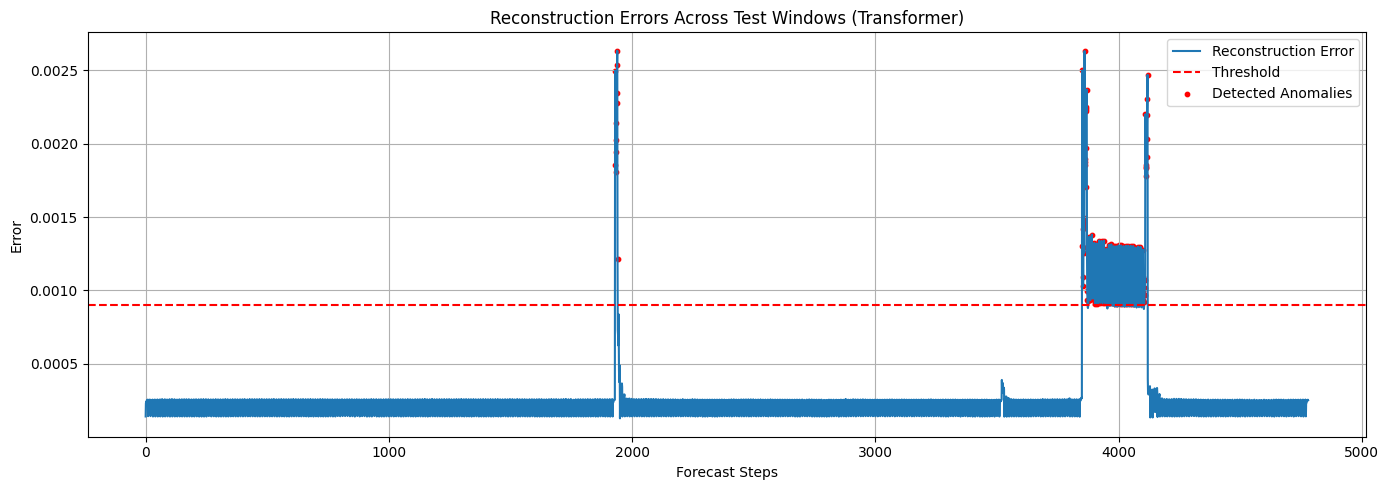

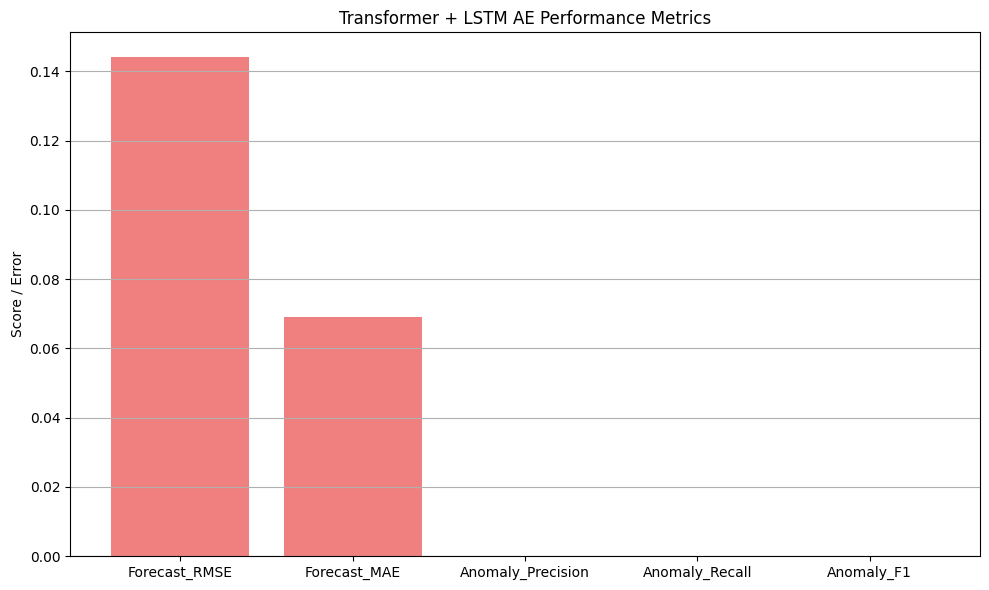

In [4]:

# ========================
# 10. EVALUATION
# ========================

# Forecasting metrics
y_pred_all = np.vstack(forecast_list)
y_true_all = np.vstack(true_windows)

forecast_rmse = np.sqrt(mean_squared_error(y_true_all.reshape(-1), y_pred_all.reshape(-1)))
forecast_mae = mean_absolute_error(y_true_all.reshape(-1), y_pred_all.reshape(-1))

print(f"\n📈 Forecasting Evaluation on Test:")
print(f"RMSE: {forecast_rmse:.5f}")
print(f"MAE:  {forecast_mae:.5f}")

# Anomaly detection metrics
all_true_labels = np.zeros_like(np.hstack(anomaly_flags_list))  # Assume all normal
all_detected = np.hstack(anomaly_flags_list)

precision = precision_score(all_true_labels, all_detected, zero_division=0)
recall = recall_score(all_true_labels, all_detected, zero_division=0)
f1 = f1_score(all_true_labels, all_detected, zero_division=0)

print(f"\n📈 Anomaly Detection Evaluation:")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")

# ========================
# 11. SAVE METRICS
# ========================

metrics_results = {
    "Model": "Transformer + LSTM AE",
    "Forecast_RMSE": forecast_rmse,
    "Forecast_MAE": forecast_mae,
    "Anomaly_Precision": precision,
    "Anomaly_Recall": recall,
    "Anomaly_F1": f1
}

metrics_df = pd.DataFrame([metrics_results])
metrics_df.to_csv("metrics_transformer_pipeline.csv", index=False)
print("\n✅ Metrics saved to 'metrics_transformer_pipeline.csv'.")

# ========================
# 12. PLOTS
# ========================

# Plot Reconstruction Errors
plt.figure(figsize=(14,5))
all_errors = np.hstack(reconstruction_errors)
plt.plot(all_errors, label='Reconstruction Error')
plt.axhline(np.percentile(all_errors, THRESHOLD_PERCENTILE), color='red', linestyle='--', label='Threshold')
plt.scatter(np.where(all_errors > np.percentile(all_errors, THRESHOLD_PERCENTILE)),
            all_errors[all_errors > np.percentile(all_errors, THRESHOLD_PERCENTILE)],
            color='red', label='Detected Anomalies', s=10)
plt.title("Reconstruction Errors Across Test Windows (Transformer)")
plt.xlabel("Forecast Steps")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_transformer.png")
plt.show()

# Plot Metrics
metric_names = ["Forecast_RMSE", "Forecast_MAE", "Anomaly_Precision", "Anomaly_Recall", "Anomaly_F1"]
metric_values = [forecast_rmse, forecast_mae, precision, recall, f1]

plt.figure(figsize=(10,6))
plt.bar(metric_names, metric_values, color='lightcoral')
plt.title("Transformer + LSTM AE Performance Metrics")
plt.ylabel("Score / Error")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("metrics_bar_chart_transformer.png")
plt.show()
